#Captcha Recognition Project




### About Dataset
This dataset contains 64 962 captcha images taken from http://captchas.net. File names are labels or each individual captcha. This dataset can be used for captcha recognition or trying to get each letter from image. Have fun!

LINK -  https://www.kaggle.com/datasets/surenbobby/captchas-net


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [159]:
!unzip '/content/drive/MyDrive/project_dataset_captcha.zip' -d '/content/'

##Setup

In [160]:
import os
from pathlib import Path
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint


##Data Loading

In [161]:
DATA_DIR = Path('/content/images_before_edit/')

BATCH_SIZE = 64
IMG_WIDTH = 200
IMG_HEIGHT = 50
MAX_LENGTH = 6
PREFETCH = 8
EPOCHS = 10

FILEPATH_WEIGHTS = '/content/weights-improvement-10-0.26.hdf5'


In [162]:
images = sorted(list(map(str, list(DATA_DIR.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

In [163]:
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

In [164]:
digits = sorted(characters)[:10]
letters = sorted(characters)[10:]

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))

Number of images found:  64961
Number of labels found:  64961
Number of unique characters:  36


## Coder and encoder for labels

In [165]:
# converting a characters into number 
char_to_num = keras.layers.StringLookup(
    vocabulary=list(characters), mask_token=None)


# converting vice versa
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

## Data manipulation

###Split data
- Train Dataset : 80 %
- Validation Dataset : 10 %
- Test Dataset : 10 %

In [166]:
def split_data(images, labels, tran_size=0.8, shuffle=True):

    size = len(images)
    np.random.seed(123)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
        
    samples_80 = int(len(images) * tran_size)
    samples_90 = int(len(images) * (tran_size + (1 - tran_size) / 2))

    x_train, y_train = images[indices[:samples_80]], labels[indices[:samples_80]]
    x_valid, y_valid = images[indices[samples_80:samples_90]], labels[indices[samples_80:samples_90]]
    x_test, y_test = images[indices[samples_90:]], labels[indices[samples_90:]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test

Form an np.arrays

In [167]:
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

## Encoding the data

In [168]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

##Create Dataset objects

In [169]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

print(type(train_dataset))

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH) 
)
print(type(train_dataset))

validation_dataset  = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH) 
)

test_dataset  = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH)
)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


## Train data visualization

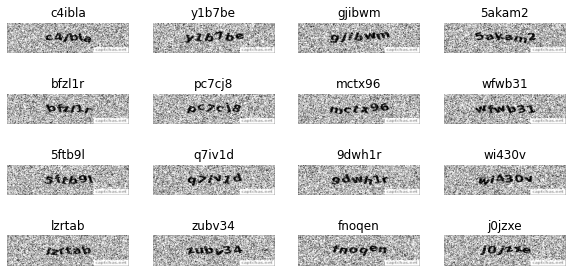

In [170]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

##Bulding an OCR model (CRNN) with CTC-loss-function

In [171]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [172]:
def build_model():
    input_img = keras.layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = keras.layers.Input(name="label", shape=(None,), dtype="float32")

    # 1 Conv2D()
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 2 Conv2D()
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    opt = keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt)  #metrics=tf.keras.metrics.Accuracy()

    return model

In [173]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

##Training with saving ModelCheckpoint

In [ ]:
filepath="--"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
callbacks_list = [checkpoint]

history = model.fit(train_dataset, 
                    validation_data=validation_dataset, 
                    epochs=EPOCHS,
                    callbacks=[checkpoint])

##Load trained model weights

In [174]:
model.load_weights(FILEPATH_WEIGHTS)

## Inherence

In [175]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [176]:
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

In [177]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
  
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :MAX_LENGTH
    ]
   
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [178]:
def get_predictions(dataset):
    
    predictions = []
    true_labels = []

    for batch in dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        test_preds = prediction_model.predict(batch_images)
        test_preds = decode_batch_predictions(test_preds)

        predictions.extend(test_preds)

        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            true_labels.append(label)

    return predictions, true_labels

## Metrics 

In [179]:
def WER(predictions, true_labels):

    difference = 0
    for i in range(len(predictions)):
        if predictions[i] != true_labels[i]:
            difference += 1

    wer_score = difference / len(predictions)
    wer_score *= 100

    print(f'Not matching {difference} / {len(predictions)}')

    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f} %")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 5):
        print(f"Ground truth : {true_labels[i]}")
        print(f"Prediction   : {predictions[i]}")
        print("-" * 100)
    return wer_score


In [180]:
def edit_distance(string1, string2):

    len_st_1 = len(string1)
    len_st_2 = len(string2)

    if len_st_1 > len_st_2:
        difference = len_st_1 - len_st_2
      
    elif len_st_2 > len_st_1:
        difference = len_st_2 - len_st_1
        
    else:
        difference = 0

    for i in range(len_st_1):
        if string1[i] != string2[i]:
            difference += 1
            
    return difference

In [181]:
def CER(predictions, true_labels):
    wrong_preds = []
    right_labels = []
    edit_distances = []
    bad_edit_distances = []

    for i in range(len(predictions)):
        distance = edit_distance(predictions[i], true_labels[i])
        if distance >= 1:
            wrong_preds.append(predictions[i])
            right_labels.append(true_labels[i])
            bad_edit_distances.append(round(distance/MAX_LENGTH, 3))
        edit_distances.append(distance/MAX_LENGTH)

    cer_score = np.mean(edit_distances) * 100

    print(f'Not matching {edit_distance(predictions, true_labels)}')

    print("-" * 100)
    print(f"Character Error Rate: {cer_score:.2f} %")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 5):
        print(f"Ground truth : {true_labels[i]}")
        print(f"Prediction   : {predictions[i]}")
        print("-" * 100)

    return cer_score, wrong_preds, right_labels, bad_edit_distances, edit_distances

## Accuracy

In [182]:
preds, truths = get_predictions(test_dataset)

In [183]:
wer = WER(preds, truths)

Not matching 203 / 6497
----------------------------------------------------------------------------------------------------
Word Error Rate: 3.1245 %
----------------------------------------------------------------------------------------------------
Ground truth : dojfkt
Prediction   : dojfkt
----------------------------------------------------------------------------------------------------
Ground truth : rnavd4
Prediction   : rnavd4
----------------------------------------------------------------------------------------------------
Ground truth : kgdw2r
Prediction   : kgdw2r
----------------------------------------------------------------------------------------------------
Ground truth : ylpy5j
Prediction   : ylpy5j
----------------------------------------------------------------------------------------------------
Ground truth : 685hcp
Prediction   : 685hcp
----------------------------------------------------------------------------------------------------


In [184]:
cer = CER(preds, truths)

Not matching 203
----------------------------------------------------------------------------------------------------
Character Error Rate: 0.83 %
----------------------------------------------------------------------------------------------------
Ground truth : jgj7en
Prediction   : jgj7en
----------------------------------------------------------------------------------------------------
Ground truth : zwncpx
Prediction   : zwncpx
----------------------------------------------------------------------------------------------------
Ground truth : cmqqo7
Prediction   : cmqqo7
----------------------------------------------------------------------------------------------------
Ground truth : tszgnx
Prediction   : tszgnx
----------------------------------------------------------------------------------------------------
Ground truth : sja7h8
Prediction   : sja7h8
----------------------------------------------------------------------------------------------------


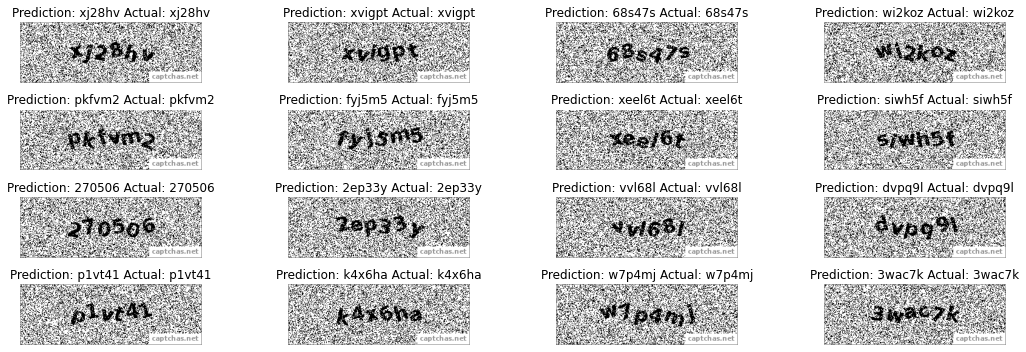

In [185]:
n_cols = 4
n_rows = 4
lists = []

preds = preds[64:]
truths = truths[64:]


fig, ax = plt.subplots(n_cols, n_rows, figsize=(15, 5))
for i in range(n_cols*n_rows):
    img = plt.imread(f'/content/images_before_edit/{truths[i]}.png')
    title = f"Prediction: {preds[i]} Actual: {truths[i]}"
    lists.append(f"Prediction: {preds[i]} Actual: {truths[i]}")
    ax[i // n_cols, i % n_rows].imshow(img, cmap="gray")
    ax[i // n_cols, i % n_rows].set_title(title)
    ax[i // n_cols, i % n_rows].axis("off")

plt.tight_layout()
plt.show()